In [1]:
!pip install bpemb

     |████████████████████████████████| 1.0MB 5.2MB/s 


In [0]:
import codecs
import errno
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision.datasets.mnist
from torchvision import transforms
from tqdm import tqdm
from bpemb import BPEmb

In [3]:
bpemb_en = BPEmb(lang="en", dim=300, vs=20000)

BPEmb fallback: en from vocab size 20000 to 200000
downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs200000.model


100%|██████████| 3776868/3776868 [00:00<00:00, 3892859.18B/s]


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs200000.d300.w2v.bin.tar.gz


100%|██████████| 224330457/224330457 [00:10<00:00, 20638367.58B/s]
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [4]:
bpemb_en.vectors.shape

(200000, 300)

In [5]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

In [0]:
X = newsgroups_train.data+newsgroups_test.data
Y = list(newsgroups_train.target)+list(newsgroups_test.target)

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [8]:
len(X_train), len(X_test)

(15076, 3770)

In [0]:
import pandas as pd

In [0]:
def pad(txt):
    txt = list(txt)
    max_len = 300
    if len(txt) <= max_len:
      l = len(txt)
      add = [bpemb_en.encode_ids('pad')[0]] * int(max_len-l)
      return txt + add    
    else:
      return txt[:max_len]

In [0]:
class BalancedPair(torch.utils.data.Dataset):

  def __init__(self, data, labels, max_len = 300, n = 1):
    
      self.n_repeat = n
      self.data = pd.DataFrame({'text': data, 'label' : labels})
      self.data['ids_']  = self.data.text.apply(bpemb_en.encode_ids)
      #self.data['ids_']  = self.data.ids_.apply(set)
      self.data['ids']  = self.data.ids_.apply(pad)
      self.train_labels = []
      self.anchores = []
      self.pos = []
      self.neg = []
      
      for text, lbl in tqdm(zip(self.data.ids.tolist(), self.data.label.tolist())):
        anchore = np.array([text]*self.n_repeat)
        labels = [lbl]*n
        j=[]
        for i in self.data.ids[self.data.label==lbl].sample(self.n_repeat, replace=True).values:
          j+=i
        pos_example = np.array(j).reshape(self.n_repeat, max_len)
        j=[]
        for i in self.data.ids[self.data.label!=lbl].sample(self.n_repeat, replace = True).values:
          j+=i
        neg_example = np.array(j).reshape(self.n_repeat, max_len)
        self.anchores.append(anchore)
        self.pos.append(pos_example)
        self.neg.append(neg_example)
        self.train_labels+=labels
      self.anch = np.concatenate(self.anchores)
      self.p = np.concatenate(self.pos)
      self.n = np.concatenate(self.neg)
      self.train_labels = torch.tensor(self.train_labels).unsqueeze(1)

  def __getitem__(self, index):
    imgs, target = (torch.LongTensor(self.anch[index]), torch.LongTensor(self.p[index]), torch.LongTensor(self.n[index])), self.train_labels[index]
    return imgs, target
   
  def __len__(self):
    return int(self.data.shape[0]*self.n_repeat)


In [12]:
train = BalancedPair(X_train, Y_train, n = 3)
train_loader = torch.utils.data.DataLoader(train, batch_size=512, shuffle=False)
test = BalancedPair(X_test, Y_test, n = 1)
test_loader = torch.utils.data.DataLoader(test, batch_size=512, shuffle=False)

15076it [00:32, 464.89it/s]
3770it [00:06, 563.82it/s]


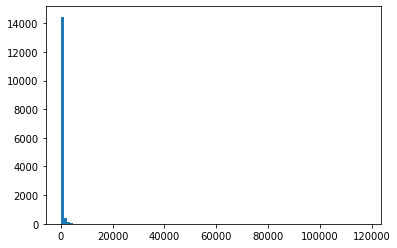

In [13]:
import matplotlib.pyplot as plt 
plt.hist(train.data.ids_.apply(len), bins=100)
plt.show()

In [0]:
for instance in list(tqdm._instances):
    tqdm._decr_instances(instance)

In [15]:
for i, j in train_loader:
  print(i[0], i[1], i[2],  j.shape)
  break

tensor([[   130, 199948, 148671,  ...,   6643,   6643,   6643],
        [   130, 199948, 148671,  ...,   6643,   6643,   6643],
        [   130, 199948, 148671,  ...,   6643,   6643,   6643],
        ...,
        [   130, 199948,     79,  ...,     42,    215,      0],
        [   130, 199948,   1686,  ...,     27,      4,  14917],
        [   130, 199948,   1686,  ...,     27,      4,  14917]]) tensor([[   130, 199948,  25252,  ..., 199937, 199915,    309],
        [   130, 199948,     66,  ...,   6643,   6643,   6643],
        [   130, 199948,  21166,  ...,   6643,   6643,   6643],
        ...,
        [   130, 199948,  36337,  ...,   6643,   6643,   6643],
        [   130, 199948,      3,  ...,   6643,   6643,   6643],
        [   130, 199948,  14312,  ...,  74448, 199937, 199920]]) tensor([[   130, 199948,     21,  ...,    678,     32,  34859],
        [   130, 199948,     99,  ...,   6643,   6643,   6643],
        [   130, 199948,    103,  ...,   6643,   6643,   6643],
        ...,

In [0]:
from math import sqrt
class model_with_att(torch.nn.Module):

  def __init__(self, matrix_w, con_filter, n):
        
        super().__init__()
        
        self.con_filter = con_filter
        self.matrix_w = matrix_w
        self.n = int(n)

        self.num_embeddings, self.embedding_dim = self.matrix_w.shape
        self.emb_layer = torch.nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.emb_layer.load_state_dict({'weight': torch.tensor(self.matrix_w)})
        self.emb_layer.weight.requires_grad = True
        self.drop = torch.nn.Dropout(0.05)

        self.cnn_3gr = torch.nn.Conv1d(in_channels= self.embedding_dim , out_channels=self.con_filter, kernel_size=3, stride = 2)
        self.cnn_4gr = torch.nn.Conv1d(in_channels=self.embedding_dim , out_channels=self.con_filter, kernel_size=4, stride = 3)
        self.cnn_5gr = torch.nn.Conv1d(in_channels=self.embedding_dim , out_channels=self.con_filter, kernel_size=5, stride = 4)
        
        self.linear_1 = torch.nn.Linear(in_features=self.con_filter*3, out_features=n)
        gl = sqrt(6./(self.con_filter*3 + n))
        self.linear_1.weight.data.uniform_(-gl, gl)

  def seq(self, x):
    x_emb = self.emb_layer(x)
    x_emb = x_emb.transpose(2,1)

    x_cnn3 = self.cnn_3gr(x_emb)
    x_cnn4 = self.cnn_4gr(x_emb)
    x_cnn5 = self.cnn_5gr(x_emb)

    frst, _ =  x_cnn3.max(dim= -1,)
    sc, _ = x_cnn4.max(dim= -1,)
    thr, _ = x_cnn5.max(dim= -1,)
    px = torch.cat((frst, sc, thr), dim=-1)
    
    return F.relu(self.linear_1(self.drop(px)))
        
  def forward(self, a, p, n):
    return self.seq(a), self.seq(p), self.seq(n)

In [0]:
from math import sqrt
class model_with_att(torch.nn.Module):

  def __init__(self, matrix_w, con_filter, n):
        
        super().__init__()
        
        self.con_filter = con_filter
        self.matrix_w = matrix_w
        self.n = int(n)

        self.num_embeddings, self.embedding_dim = self.matrix_w.shape
        self.emb_layer = torch.nn.Embedding(self.num_embeddings, self.embedding_dim)
        self.emb_layer.load_state_dict({'weight': torch.tensor(self.matrix_w)})
        self.emb_layer.weight.requires_grad = True
        self.drop = torch.nn.Dropout(0.05)

        self.lstm_f = nn.LSTM(self.embedding_dim, self.con_filter, batch_first = True, dropout = 0.1 )
        self.lstm_s = nn.LSTM(self.embedding_dim, self.con_filter, batch_first = True, dropout = 0.1 )

        self.linear_1 = torch.nn.Linear(in_features=self.con_filter*2, out_features=n)
        gl = sqrt(6./(self.con_filter + n))
        self.linear_1.weight.data.uniform_(-gl, gl)

  def seq(self, x):
    x_emb = self.emb_layer(x)
    x_lstm_F, _ = self.lstm_f(x_emb[:,:150,:])
    x_lstm_S, _ = self.lstm_f(x_emb[:,150:,:])
    x_last_f = x_lstm_F[:,-1,:]
    x_last_s = x_lstm_S[:,-1,:]
    x_last = torch.cat((x_last_f, x_last_f), dim=-1)
    return F.relu(self.linear_1(self.drop(x_last)))
        
  def forward(self, a, p, n):
    return self.seq(a), self.seq(p), self.seq(n)

In [18]:
model = model_with_att(bpemb_en.vectors, 300, 300)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [19]:
model

model_with_att(
  (emb_layer): Embedding(200000, 300)
  (drop): Dropout(p=0.05, inplace=False)
  (lstm_f): LSTM(300, 300, batch_first=True, dropout=0.1)
  (lstm_s): LSTM(300, 300, batch_first=True, dropout=0.1)
  (linear_1): Linear(in_features=600, out_features=300, bias=True)
)

In [0]:
with torch.no_grad():  
  a,p,n = model(i[0],i[1], i[2])

In [21]:
a.size()

torch.Size([512, 300])

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [0]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
model = model.to(device)

In [0]:
criterion = torch.nn.TripletMarginLoss(margin=3)
criterion = criterion.to(device)

In [25]:
train_knn = BalancedPair(X_train, Y_train, n = 1)
train_knn_loader = torch.utils.data.DataLoader(train_knn, batch_size=256, shuffle=False)

15076it [00:29, 509.58it/s]


In [0]:
def loss_f(a, h):
  norm1 = torch.sum(a**2, dim=1)
  norm2 = torch.sum(h**2, dim=1)
  dist = a - h
  dist_p = dist.pow(2)
  dist_s = dist_p.sum(axis=1)
  dist_sq = torch.sqrt(dist_s)
  #dist_sq_p = dist_sq.pow(2)
  return dist_sq

In [0]:
def train(model, device, train_loader, epoch, optimizer, alpha = 3, bs = 512):

  model.train()
  losses = []
  al = [alpha]*bs
  progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch #{}'.format(epoch))
  for batch_idx, (data, target) in enumerate(train_loader):
    for i in range(len(data)):
        data[i] = data[i].to(device)
        
    optimizer.zero_grad()
    a, p, n = model(data[0], data[1], data[2])

    #loss_p = loss_f(a, p)
    #loss_n = loss_f(a, n)

    #loss = (F.relu(torch.tensor(al)[:loss_n.shape[0]]+ loss_p - loss_n)).mean()

    loss = criterion(a,p,n)

    losses.append(loss.item())
    loss.backward()

    optimizer.step()

    progress_bar.set_postfix(train_loss = np.mean(losses[-500:]))
    progress_bar.update(data[0].shape[0])
  progress_bar.close()

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [0]:
def create_knn(model, train_knn_loader, device, k = 200):
  train_vectors = []
  model.eval()
  losses = []
  for (data, target) in tqdm(train_knn_loader):
    data[0] = data[0].to(device)
    a = model.seq(data[0])
    train_vectors.append(a.detach().cpu().numpy())
  train_vectors = np.concatenate(train_vectors, axis = 0)
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh.fit(train_vectors, np.array(Y_train))
  return neigh, train_vectors


In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def valid(knn, model, device, test_loader):
  test_vectors = []
  model.eval()
  losses = []
  for (data, target) in tqdm(test_loader):
    data[0] = data[0].to(device)
    a = model.seq(data[0])
    test_vectors.append(a.detach().cpu().numpy())
  test_vectors = np.concatenate(test_vectors, axis = 0)
  preds = knn.predict(test_vectors)
  print('\nF1 :', f1_score(preds, np.array(Y_test), average = 'weighted'))
  print('\nAcc :', accuracy_score(preds, np.array(Y_test)))

#valid(knn, model, device, test_loader)

In [31]:
for i in range(5):
  train(model, device, train_loader, i, optimizer)
  knn, vecs = create_knn(model, train_knn_loader, device)
  valid(knn, model, device, test_loader)

Epoch #1:   0%|          | 0/45228 [00:00<?, ?it/s]


F1 : 0.34447886075577794

Acc : 0.3153846153846154


Epoch #2:   0%|          | 0/45228 [00:00<?, ?it/s]


F1 : 0.504813906837633

Acc : 0.47745358090185674


Epoch #3:   0%|          | 0/45228 [00:00<?, ?it/s]


F1 : 0.543128049061014

Acc : 0.523342175066313


Epoch #4:   0%|          | 0/45228 [00:00<?, ?it/s]


F1 : 0.5904788739859899

Acc : 0.5777188328912467


100%|██████████| 8/8 [00:20<00:00,  2.24s/it]



F1 : 0.5902325571429978

Acc : 0.5795755968169761


In [0]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(vecs)

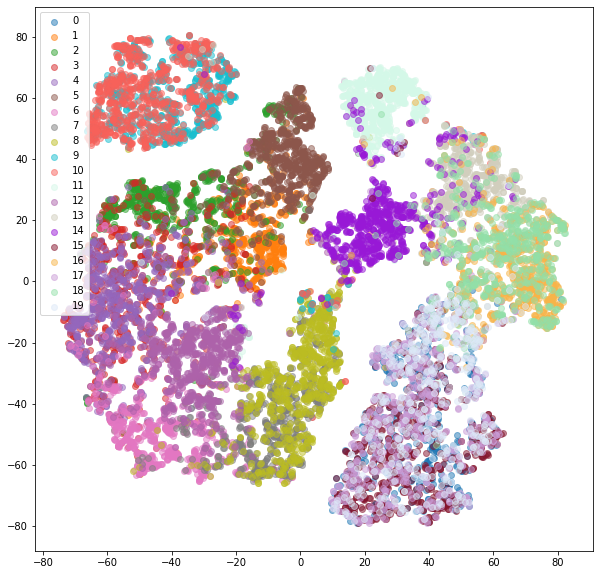

In [33]:
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

classes = np.unique(np.array(Y_train))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#f8615a', '#d4f8e8', '#ad62aa', '#d1cebd', '#9818d6', '#84142d', '#f7b449', '#ca9dd7', '#92e0a9', '#dde9f8', '#96c99c']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(len(classes)):
        inds = np.where(np.array(Y_train)==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

plot_embeddings(X_embedded, newsgroups_train.target )